<a href="https://colab.research.google.com/github/sugi-san/kapao/blob/master/kapao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

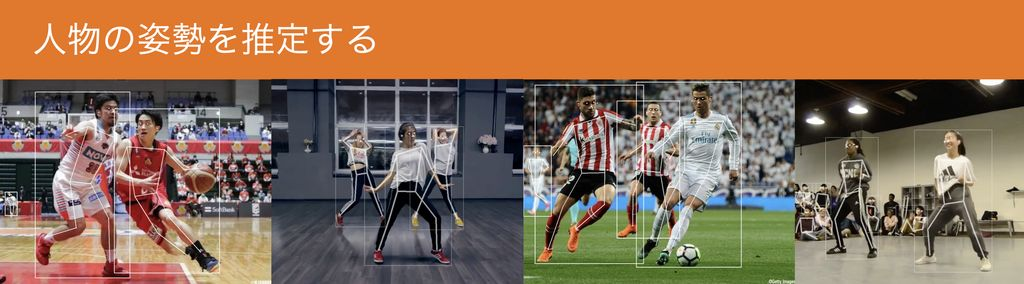

In [ ]:
#@title 1.セットアップ

from IPython.utils import io
import os
import subprocess
import tqdm.notebook

TQDM_BAR_FORMAT = '{l_bar}{bar}| {n_fmt}/{total_fmt} [elapsed: {elapsed} remaining: {remaining}]'

try:
  with tqdm.notebook.tqdm(total=100, bar_format=TQDM_BAR_FORMAT) as pbar:
    with io.capture_output() as captured:

      # githubからコードを取得
      ! git clone https://github.com/sugi-san/kapao.git
      %cd kapao
      pbar.update(15)

      # ライブラリー・インストール
      ! pip install -r requirements.txt
      pbar.update(70)

      # 学習済みパラメータ・ダウンロード
      ! python data/scripts/download_models.py
      pbar.update(10)

      from moviepy.editor import *
      pbar.update(5)

except subprocess.CalledProcessError:
  print(captured)
  raise

# ビデオ長さ取得
def get_duration(file_path):
    clip = VideoFileClip(file_path)
    return int(clip.duration) 


# 表示関数
import matplotlib.pyplot as plt
from PIL import Image
import os
import numpy as np

def display_pic(folder):
    fig = plt.figure(figsize=(20, 20))
    files = os.listdir(folder)
    files.sort()
    for i, file in enumerate(files):
        if file == '.ipynb_checkpoints':
          continue  
        img = Image.open(folder+'/'+file) 
        images = np.asarray(img)
        ax = fig.add_subplot(5, 5, i+1, xticks=[], yticks=[])
        image_plt = np.array(images)
        ax.imshow(image_plt)
        ax.set_xlabel(file, fontsize=20)               
    plt.show()
    plt.close()


# サイズ調整関数
import cv2

def size_opt(file):
    max_size = 1280
    npyImage = cv2.imread(filename = file, flags = cv2.IMREAD_COLOR)
    intWidth = npyImage.shape[1]
    intHeight = npyImage.shape[0]

    fltRatio = float(intWidth) / float(intHeight)
    intWidth = min(int(max_size * fltRatio), max_size)
    intHeight = min(int(max_size / fltRatio), max_size)

    # ピクセルを偶数にする
    if not intWidth % 2 == 0:
      intWidth +=1
    if not intHeight % 2 ==0:
      intHeight +=1

    npyImage = cv2.resize(src=npyImage, dsize=(intWidth, intHeight), fx=0.0, fy=0.0, interpolation=cv2.INTER_AREA)
    cv2.imwrite(file, npyImage)

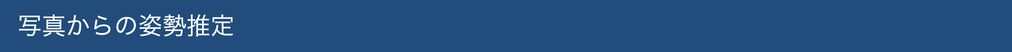

In [ ]:
#@title 2.写真の表示
display_pic('image')

In [ ]:
#@title 3.写真の姿勢推定

# 画像指定
image = '02.jpg' #@param {type:"string"}
image_path = 'image/'+image

# 姿勢推定
! python demos/image.py -p $image_path\
                        --bbox\
                        --pose\
                        --face\
                        --color-pose 255 255 255\
                        --color-kp 255 255 255\
                        --line-thick 2

# 画像表示                                  
from google.colab.patches import cv2_imshow
import cv2
img_cv=cv2.imread("out.png")
cv2_imshow(img_cv)

In [ ]:
#@title 4.画像のダウンロード
import os
import shutil
from google.colab import files

name = os.path.splitext(image)
file_name = name[0]+'_pose.png'
shutil.copy('out.png', file_name)
files.download(file_name)

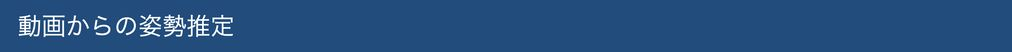

In [ ]:
#@title 5.動画の表示
import glob
files = sorted(os.listdir('video'))
print('===video===')
for file in files:
    if file == '.ipynb_checkpoints':
      continue    
    print(file)
    

In [ ]:
#@title 6.動画の姿勢推定
# 動画指定
video = '01.mp4' #@param {type:"string"}
video_path = 'video/'+video

# リセットファイル
import os
if os.path.exists('./tmp.mp4'):
   os.remove('./tmp.mp4') 

# 動画をtmp.mp4へコピー（30秒を超えたら30秒でカット）
import shutil
duration = get_duration(video_path)
if duration >40:
  print('keep the video within 30 seconds...')
  ! ffmpeg -i $video_path -ss 00:00:00.00 -t 00:00:30 -loglevel error tmp.mp4  
else:
  shutil.copy(video_path, 'tmp.mp4')

# ビデオ長さ取得
duration = get_duration('tmp.mp4')+1

# 姿勢推定
! python demos/video.py -p tmp.mp4\
                        --weights kapao_l_coco.pt\
                        --conf-thres-kp 0.01\
                        --kp-obj\
                        --face\
                        --start 0\
                        --end $duration

# リセットファイル
if os.path.exists('./output.mp4'):
   os.remove('./output.mp4')

# 音声の抽出＆付加
print('preparation for sound...')
! ffmpeg -y -i tmp.mp4 -loglevel error sound.mp3
! ffmpeg -i out.mp4 -i sound.mp3 -loglevel error output.mp4

# 動画の再生
print('preparation for video...')
from IPython.display import HTML
from base64 import b64encode
mp4 = open('output.mp4', 'rb').read()
data_url = 'data:video/mp4;base64,' + b64encode(mp4).decode()
HTML(f"""
<video width="100%" height="100%" controls>
      <source src="{data_url}" type="video/mp4">
</video>""")


In [ ]:
#@title 7.動画のダウンロード
import os
import shutil
from google.colab import files

name = os.path.splitext(video)
file_name = name[0]+'_pose.mp4'
shutil.copy('output.mp4', file_name)
files.download(file_name)

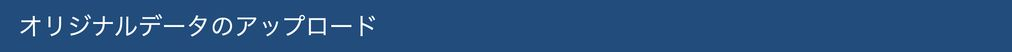

In [ ]:
#@title 8.画像や動画のアップロード
#@markdown ・selectで写真（jpg）か動画（mp4）を選択\
#@markdown ・動画はHD(1280×720)以下、30秒以内

import os
import shutil
from google.colab import files
import cv2

select = 'image' #@param ["image", "video"]

# ルートへ画像をアップロード
uploaded = files.upload()           
uploaded = list(uploaded.keys())    

# ルートから指定フォルダーへ移動
for file in uploaded:
    if select == 'image':
      size_opt(file)
    shutil.move(file, select+'/'+file)  

###【備考】
・ブラウザは、必ずGoogle Chromeを使用して下さい。

・動作がおかしくなった場合の対応\
１）グーグルクロームの該当タブを削除して接続を切る\
２）再度リンクを開く\
３）右上にある「ランタイム／ランタイムを出荷時設定にリセット」をクリックする（下記写真を参照に下さい）\
４）あとは、動画にある通りの操作をすればOK

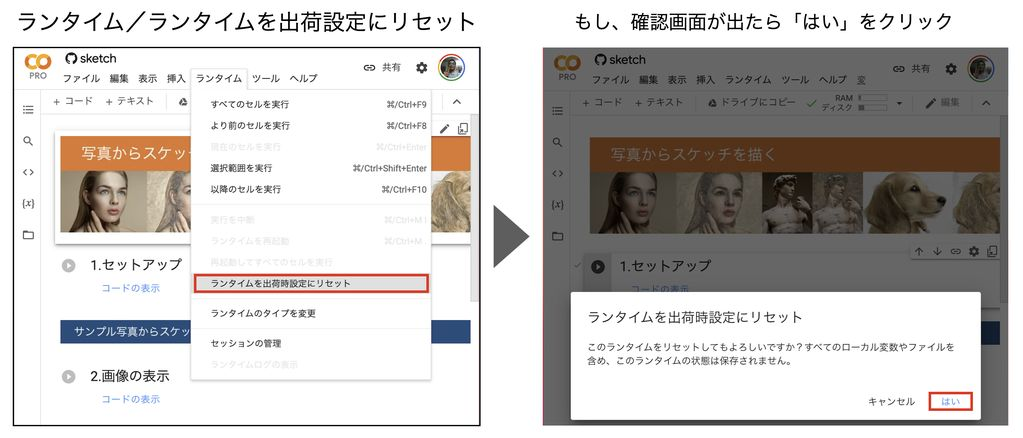